In [1]:
from pathlib import Path
from IPython.display import HTML, display
css = Path("../../../css/custom.css").read_text(encoding="utf-8")
display(HTML(f"<style>{css}</style>"))

# Chapter 2 — Basics of Data and Preprocessing
## Lesson 5: Handling Outliers and Imbalanced Data

### What you will learn in this lesson

By the end of this lesson, you will be able to:

- Distinguish *data errors*, *rare-but-valid extremes*, and *distribution shift* when you see unusual values.
- Detect outliers with complementary methods (IQR, z-score, robust z/MAD, multivariate anomaly detection).
- Choose an outlier treatment strategy that matches the modeling goal (robust modeling vs. transformation vs. capping vs. deletion).
- Understand why class imbalance breaks “accuracy thinking” and how evaluation must change.
- Apply class-weighting, threshold tuning, and resampling (over/under-sampling, SMOTE) inside leak-safe pipelines.
- Report results with metrics that remain meaningful under imbalance (PR-AUC, F$_1$, balanced accuracy, expected cost).

This lesson is intentionally practice-heavy: you will implement techniques end-to-end, compare them, and learn when each one is appropriate.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from io import StringIO
from pathlib import Path

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.decomposition import PCA

from sklearn.metrics import (
    classification_report, confusion_matrix,
    precision_recall_curve, average_precision_score,
    roc_auc_score
)

# Optional: imbalanced-learn for resampling (recommended for this lesson)
try:
    from imblearn.over_sampling import SMOTE, RandomOverSampler
    from imblearn.under_sampling import RandomUnderSampler
    from imblearn.pipeline import Pipeline as ImbPipeline
    IMBLEARN_AVAILABLE = True
except Exception:
    IMBLEARN_AVAILABLE = False

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)


In [3]:
def _load_csv(rel_path: str, fallback_csv_text: str) -> pd.DataFrame:
    path = Path(rel_path)
    if path.exists():
        return pd.read_csv(path)
    return pd.read_csv(StringIO(fallback_csv_text))

def _expand_tabular(df: pd.DataFrame, n: int, noise_scale: float = 0.05) -> pd.DataFrame:
    """Bootstrap rows and add light noise to numeric columns for richer demos."""
    out = df.sample(n=n, replace=True, random_state=RANDOM_SEED).reset_index(drop=True).copy()
    num_cols = out.select_dtypes(include=[np.number]).columns.tolist()
    for c in num_cols:
        col = out[c].astype(float)
        # scale noise by IQR (robust) to avoid exploding tiny-variance features
        q1, q3 = np.nanpercentile(col, [25, 75])
        iqr = max(q3 - q1, 1e-9)
        noise = np.random.normal(0.0, noise_scale * iqr, size=len(out))
        out[c] = col + noise
    return out

diabetes_fallback = """Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,classification
6,148,72,35,0,33.6,0.627,50,Diabetic
1,85,66,29,0,26.6,0.351,31,Non-Diabetic
8,183,64,0,0,23.3,0.672,32,Diabetic
1,89,66,23,94,28.1,0.167,21,Non-Diabetic
0,137,40,35,168,43.1,2.288,33,Diabetic
"""
df_diabetes = _load_csv("../../../Datasets/Classification/diabetes.csv", diabetes_fallback)

# Expand for demonstration so that models/plots are informative even with small CSV excerpts.
if len(df_diabetes) < 300:
    df_diabetes = _expand_tabular(df_diabetes, n=800, noise_scale=0.10)

df_diabetes.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,classification
0,6,148,72,35,0,33.6,0.627,50,Diabetic
1,1,85,66,29,0,26.6,0.351,31,Non-Diabetic
2,8,183,64,0,0,23.3,0.672,32,Diabetic
3,1,89,66,23,94,28.1,0.167,21,Non-Diabetic
4,0,137,40,35,168,43.1,2.288,33,Diabetic


### Why outliers and imbalance matter (especially in tabular ML)

**Outliers** can dominate the objective function and distort learned parameters, especially in models that minimize squared loss or assume Gaussian-like errors. In practice, outliers can be:

- **Data quality issues** (entry errors, unit mismatches, sensor glitches).
- **Rare but legitimate cases** (fraud, extreme demand spikes, medical complications).
- **Distribution shift** (new population, changed measurement process, updated policy).

Handling outliers is not “remove them” by default. The correct move depends on whether the outlier is *wrong*, *rare-but-important*, or *a new regime*.

**Imbalanced data** occurs when one class is much rarer than the others (e.g., churn, fraud, failure, disease). Under imbalance:

- A model can achieve high accuracy by predicting only the majority class.
- Threshold choices dominate business outcomes.
- ROC-AUC can look strong even when the model is operationally weak; PR-AUC and cost-based metrics often tell the truth.

A robust practitioner treats outliers and imbalance as part of *data preprocessing + evaluation design*, not as isolated tricks.

### A minimal mental model: “Detect → Diagnose → Treat → Validate”

1. **Detect** unusual points using *more than one* method.
2. **Diagnose** why they exist (errors vs. rare valid cases vs. shift).
3. **Treat** using a strategy consistent with the task and constraints.
4. **Validate** via leak-safe evaluation: does the change improve generalization and decision outcomes?

You should be able to justify each treatment in terms of *risk*, *utility*, and *evaluation integrity*.

## Part A — Outliers

### 1) Definitions and core formulas

An “outlier” is a data point that is inconsistent with the bulk of the data under some definition of “consistent.” Common univariate detectors:

- **z-score (mean/std)**: $z_i = \dfrac{x_i - \mu}{\sigma}$  
  Works when the distribution is roughly symmetric and not heavy-tailed.
- **IQR rule**: define $IQR = Q_3 - Q_1$ and flag points outside
  $$[Q_1 - 1.5\,IQR,\; Q_3 + 1.5\,IQR].$$
  More robust than mean/std.
- **Robust z-score via MAD** (median absolute deviation):
  $$MAD = \text{median}(|x - \text{median}(x)|), \quad z^{MAD}_i = \dfrac{0.6745\,(x_i - \text{median}(x))}{MAD}.$$
  The factor $0.6745$ makes it comparable to standard deviation under a normal distribution.

Multivariate outliers are points that look normal marginally, but unusual jointly (e.g., a combination of features that rarely occurs together). For multivariate detection, we will use algorithms such as Isolation Forest and (optionally) robust covariance.

### 1.1) Outliers through the lens of optimization: why a few points can dominate

Most learning algorithms optimize an empirical objective of the form
$$\min_\theta \; \frac{1}{n}\sum_{i=1}^{n}\ell\big(y_i, f_\theta(x_i)\big) + \lambda \Omega(\theta).$$

If $\ell$ grows quickly with error (e.g., squared loss in regression), then a small number of extreme points can contribute a disproportionate share of total loss. This is the “influence” problem: a point with large loss can “pull” $\theta$ so that the model fits it, potentially worsening performance on the bulk of the data.

Practical implications:

- **Linear regression** with squared loss is highly sensitive to large residuals.
- **Distance-based models** (kNN, SVM with RBF kernel) can be sensitive to feature-scale outliers.
- **Logistic regression** is usually less sensitive than squared-loss regression, but extreme covariates can still cause unstable decision boundaries, particularly with weak regularization.
- **Trees/forests** are often robust to monotone transformations but can still be harmed by label noise and rare artifacts.

This is why “outlier handling” is not a cosmetic step: it changes the optimization landscape.

### 1.2) High leverage vs. high residual (concept you should know)

Even without doing formal regression diagnostics, it is useful to distinguish two common reasons a point is influential:

- **High residual:** the label/target is unusual given typical inputs (e.g., a transaction marked as fraud in a region where fraud is rare).
- **High leverage:** the input features are unusual (far from the bulk in feature space), so the model has to extrapolate there.

A point can be both: unusual inputs and unusual outputs.

Multivariate detectors (Isolation Forest, Mahalanobis distance) are mainly looking for **high leverage** points—unusual combinations of features.

### 1.3) Treatment strategies: a decision matrix

You can think of treatment as choosing one of four broad strategies:

1. **Fix** (data correction): unit conversion, parsing errors, range constraints, deduplication.
2. **Remove** (deletion): only when values are clearly invalid *and* removing them does not remove important regimes.
3. **Transform / cap** (winsorization, log/Box–Cox/Yeo–Johnson): keep information but reduce influence.
4. **Model robustly** (robust scaling, robust losses, tree ensembles, regularization): accept outliers as part of the data-generating process.

In high-stakes settings, you often combine strategies: you fix obvious errors, cap extreme but plausible tails, and still use robust evaluation metrics.

### 2) Practical rule: never delete outliers blindly

Before you delete anything, ask:

- Is the value *physically/semantically impossible* (e.g., negative age)?
- Is it a plausible extreme case that you **want** the model to learn?
- Is it a sign of data drift (a future regime you must handle)?
- Does removal change label distribution (and therefore bias evaluation)?

If you cannot answer these questions, use **robust treatments** (robust scaling, transformations, robust models) rather than deletion.

### 3) Dataset 1 (Classification + numeric features): `diabetes.csv`

We will use the diabetes dataset to demonstrate univariate and multivariate outlier detection, and how outlier treatments can change model behavior.

Key idea: even in “clean” benchmark datasets, some features can have heavy tails, structural zeros, or artifacts that behave like outliers during training.

In [4]:
df_diabetes.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,NaN,NaN,NaN,3.845052,3.369578,0.0,1.0,3.0,6.0,17.0
Glucose,768.0,NaN,NaN,NaN,120.894531,31.972618,0.0,99.0,117.0,140.25,199.0
BloodPressure,768.0,NaN,NaN,NaN,69.105469,19.355807,0.0,62.0,72.0,80.0,122.0
SkinThickness,768.0,NaN,NaN,NaN,20.536458,15.952218,0.0,0.0,23.0,32.0,99.0
Insulin,768.0,NaN,NaN,NaN,79.799479,115.244002,0.0,0.0,30.5,127.25,846.0
BMI,768.0,NaN,NaN,NaN,31.992578,7.88416,0.0,27.3,32.0,36.6,67.1
DiabetesPedigreeFunction,768.0,NaN,NaN,NaN,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,NaN,NaN,NaN,33.240885,11.760232,21.0,24.0,29.0,41.0,81.0
classification,768,2,Non-Diabetic,500,NaN,NaN,NaN,NaN,NaN,NaN,NaN


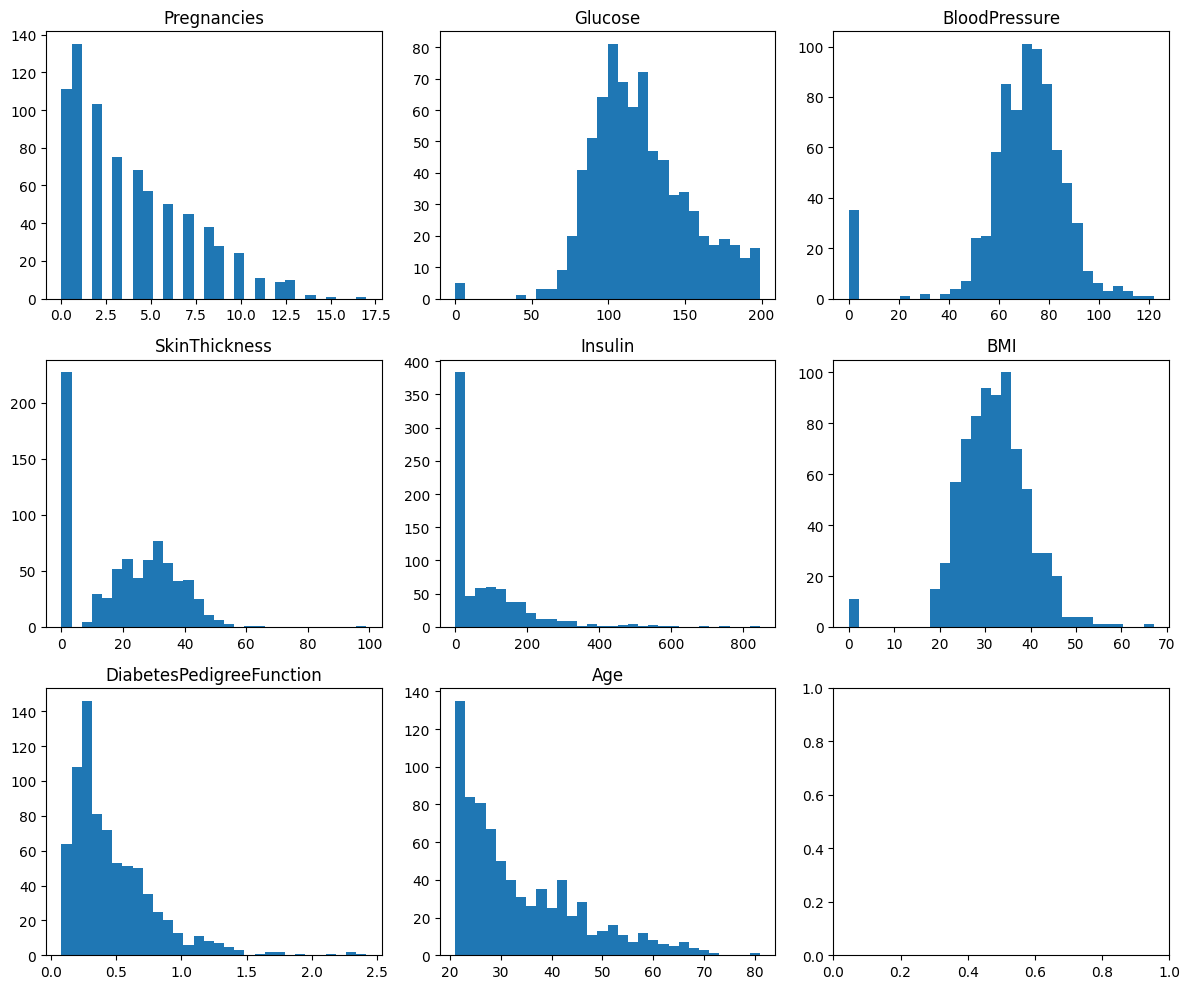

In [5]:
num_cols = [c for c in df_diabetes.columns if c != "classification"]
fig, axes = plt.subplots(3, 3, figsize=(12, 10))
axes = axes.ravel()

for i, c in enumerate(num_cols[:9]):
    axes[i].hist(df_diabetes[c].astype(float), bins=30)
    axes[i].set_title(c)

plt.tight_layout()
plt.show()


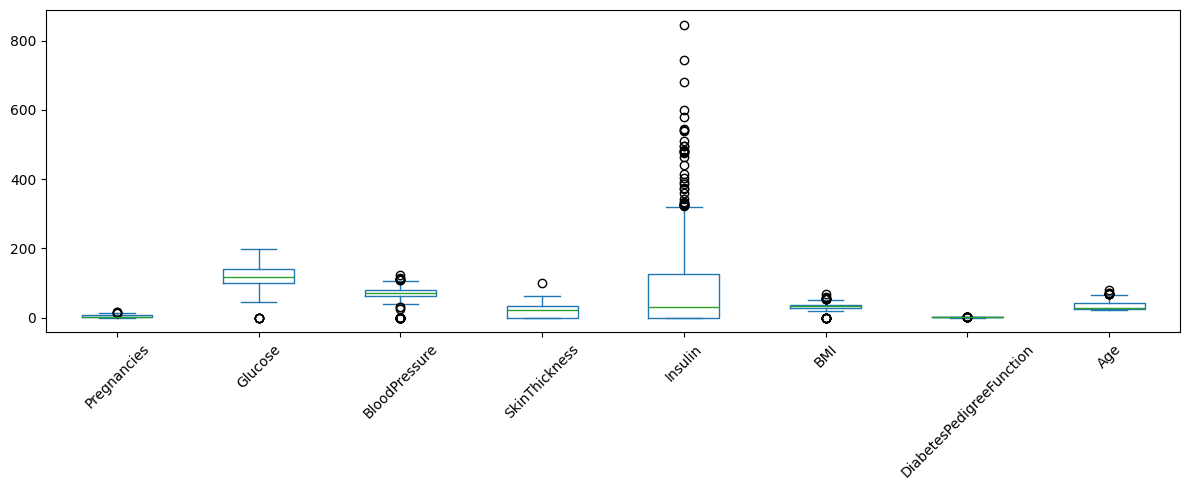

In [6]:
fig, ax = plt.subplots(figsize=(12, 5))
df_diabetes[num_cols].astype(float).plot(kind="box", ax=ax, rot=45)
plt.tight_layout()
plt.show()


In [7]:
def iqr_bounds(x: pd.Series, k: float = 1.5):
    x = x.dropna().astype(float)
    q1, q3 = np.percentile(x, [25, 75])
    iqr = q3 - q1
    lo = q1 - k * iqr
    hi = q3 + k * iqr
    return lo, hi

iqr_summary = []
for c in num_cols:
    lo, hi = iqr_bounds(df_diabetes[c])
    mask = (df_diabetes[c].astype(float) < lo) | (df_diabetes[c].astype(float) > hi)
    iqr_summary.append((c, lo, hi, int(mask.sum()), float(mask.mean())))

iqr_df = pd.DataFrame(iqr_summary, columns=["feature","lo","hi","n_outliers","outlier_rate"]).sort_values("outlier_rate", ascending=False)
iqr_df.head(10)


,feature,lo,hi,n_outliers,outlier_rate
2,BloodPressure,35.000,107.000,45,0.058594
4,Insulin,-190.875,318.125,34,0.044271
6,DiabetesPedigreeFunction,-0.330,1.200,29,0.037760
5,BMI,13.350,50.550,19,0.024740
7,Age,-1.500,66.500,9,0.011719
1,Glucose,37.125,202.125,5,0.006510
0,Pregnancies,-6.500,13.500,4,0.005208
3,SkinThickness,-48.000,80.000,1,0.001302


In [8]:
def robust_z_mad(x: pd.Series):
    x = x.astype(float)
    med = np.median(x)
    mad = np.median(np.abs(x - med))
    mad = mad if mad > 1e-12 else 1e-12
    z = 0.6745 * (x - med) / mad
    return z

feature = "Insulin"
z_mad = robust_z_mad(df_diabetes[feature].astype(float))
flags = np.abs(z_mad) > 3.5
pd.DataFrame({
    feature: df_diabetes[feature].astype(float),
    "robust_z(MAD)": z_mad,
    "flag(|z|>3.5)": flags
}).sort_values("robust_z(MAD)", ascending=False).head(10)


,Insulin,robust_z(MAD),flag(|z|>3.5)
13,846.0,18.034582,True
228,744.0,15.778877,True
247,680.0,14.363533,True
584,600.0,12.594352,True
409,579.0,12.129943,True
286,545.0,11.378041,True
8,543.0,11.333811,True
655,540.0,11.267467,True
753,510.0,10.604025,True
111,495.0,10.272303,True


In [9]:
def winsorize_series(x: pd.Series, lower_q=0.01, upper_q=0.99):
    x = x.astype(float).copy()
    lo = np.quantile(x, lower_q)
    hi = np.quantile(x, upper_q)
    return x.clip(lo, hi), lo, hi

feature = "Insulin"
x_raw = df_diabetes[feature].astype(float)
x_w, lo, hi = winsorize_series(x_raw, 0.01, 0.99)

summary = pd.DataFrame({
    "raw": x_raw.describe(percentiles=[0.01,0.05,0.5,0.95,0.99]),
    "winsorized": x_w.describe(percentiles=[0.01,0.05,0.5,0.95,0.99])
})
lo, hi, summary


(np.float64(0.0),
 np.float64(519.9000000000012),
               raw  winsorized
 count  768.000000  768.000000
 mean    79.799479   78.604427
 std    115.244002  109.425722
 min      0.000000    0.000000
 1%       0.000000    0.000000
 5%       0.000000    0.000000
 50%     30.500000   30.500000
 95%    293.000000  293.000000
 99%    519.900000  513.267000
 max    846.000000  519.900000)

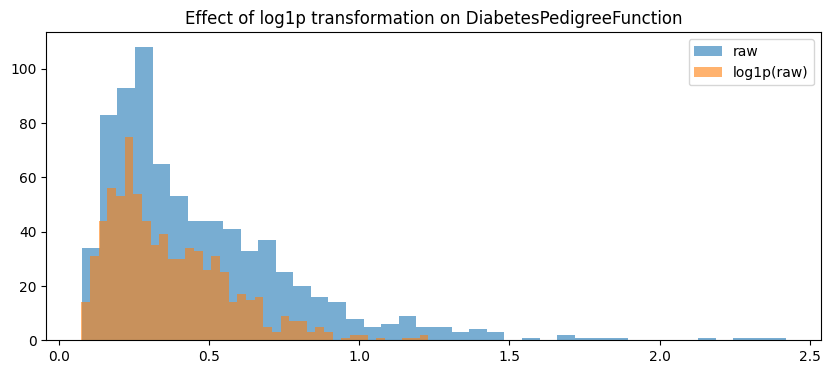

,raw,log1p
count,768.000000,768.000000
mean,0.471876,0.365317
std,0.331329,0.198510
min,0.078000,0.075107
25%,0.243750,0.218131
50%,0.372500,0.316633
75%,0.626250,0.486277
max,2.420000,1.229641


In [10]:
feature = "DiabetesPedigreeFunction"
x = df_diabetes[feature].astype(float)

# log1p is safe for non-negative values; for general features you may need shifting.
x_log = np.log1p(np.maximum(x, 0))

fig, ax = plt.subplots(figsize=(10, 4))
ax.hist(x, bins=40, alpha=0.6, label="raw")
ax.hist(x_log, bins=40, alpha=0.6, label="log1p(raw)")
ax.set_title(f"Effect of log1p transformation on {feature}")
ax.legend()
plt.show()

pd.DataFrame({"raw": x.describe(), "log1p": pd.Series(x_log).describe()})


### 3.1) Beyond log: Box–Cox and Yeo–Johnson (practical guidance)

Log transforms are useful, but they require non-negative values (or a shift). More general “power transforms” can stabilize variance and reduce skew:

- **Box–Cox**: defined for strictly positive data; chooses a power parameter $\lambda$ to make the distribution more Gaussian-like.
- **Yeo–Johnson**: similar idea, but supports zero and negative values.

These transforms can make linear models behave better (more linear relationships, less tail influence). However:

- They can reduce interpretability (the feature is now in a transformed space).
- The transformation must be fit on training data only (pipeline discipline).
- For tree models, improvements may be smaller, because trees are invariant to monotone transforms in many situations.

We will demonstrate Yeo–Johnson with `PowerTransformer`.

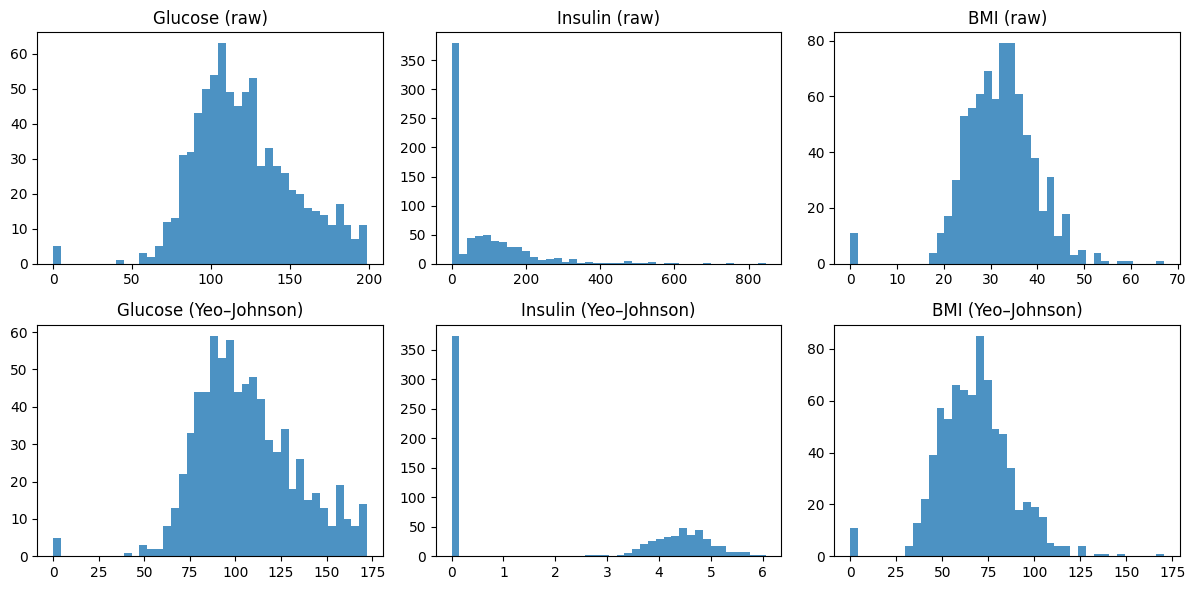

,feature,lambda
0,Glucose,0.966405
1,Insulin,-0.032285
2,BMI,1.276566


In [11]:
from sklearn.preprocessing import PowerTransformer

features = ["Glucose", "Insulin", "BMI"]
X_raw = df_diabetes[features].astype(float).copy()

pt = PowerTransformer(method="yeo-johnson", standardize=False)
X_pt = pt.fit_transform(X_raw)

fig, axes = plt.subplots(2, 3, figsize=(12, 6))
for j, f in enumerate(features):
    axes[0, j].hist(X_raw[f], bins=40, alpha=0.8)
    axes[0, j].set_title(f"{f} (raw)")
    axes[1, j].hist(X_pt[:, j], bins=40, alpha=0.8)
    axes[1, j].set_title(f"{f} (Yeo–Johnson)")
plt.tight_layout()
plt.show()

pd.DataFrame({"feature": features, "lambda": pt.lambdas_})


### 3.2) Robust scaling vs. standard scaling (when to prefer which)

- **StandardScaler** centers by mean and scales by standard deviation. It works well when features are roughly symmetric and not dominated by extreme tails.
- **RobustScaler** centers by median and scales by IQR. It is much less sensitive to heavy tails and is often a good default for real-world tabular data.

A useful pattern is:

- Start with RobustScaler for linear / distance-based models.
- If diagnostics show approximately Gaussian features (and outliers are controlled), StandardScaler is fine.
- For tree models, scaling often matters less, but it can still help when you mix models or use algorithms that are not tree-based.

Below we compare the effect on quantiles for a few features.

In [12]:
check = ["Glucose", "Insulin", "BMI"]
X = df_diabetes[check].astype(float).values

std = StandardScaler().fit_transform(X)
rob = RobustScaler().fit_transform(X)

def qstats(arr):
    return np.percentile(arr, [1, 5, 25, 50, 75, 95, 99])

rows = []
for j,f in enumerate(check):
    rows.append((f, qstats(X[:,j]), qstats(std[:,j]), qstats(rob[:,j])))

out = []
for f, q_raw, q_std, q_rob in rows:
    out.append(pd.DataFrame({
        "percentile": [1,5,25,50,75,95,99],
        "raw": q_raw,
        "standard_scaled": q_std,
        "robust_scaled": q_rob
    }).assign(feature=f))

pd.concat(out, axis=0).head(14)


,percentile,raw,standard_scaled,robust_scaled,feature
0,1,57.00,-1.999716,-1.454545,Glucose
1,5,79.00,-1.311179,-0.921212,Glucose
2,25,99.00,-0.685236,-0.436364,Glucose
3,50,117.00,-0.121888,0.000000,Glucose
4,75,140.25,0.605771,0.563636,Glucose
5,95,181.00,1.881130,1.551515,Glucose
6,99,196.00,2.350587,1.915152,Glucose
0,1,0.00,-0.692891,-0.239686,Insulin
1,5,0.00,-0.692891,-0.239686,Insulin
2,25,0.00,-0.692891,-0.239686,Insulin


In [13]:
X = df_diabetes[num_cols].astype(float).values
iso = IsolationForest(
    n_estimators=300,
    contamination=0.03,
    random_state=RANDOM_SEED
)
iso.fit(X)

# Higher score => more normal; lower => more anomalous
scores = iso.score_samples(X)
labels = iso.predict(X)  # -1 outlier, +1 inlier

outlier_idx = np.argsort(scores)[:10]
pd.DataFrame(df_diabetes.loc[outlier_idx, num_cols].astype(float)).assign(anomaly_score=scores[outlier_idx], iso_label=labels[outlier_idx])


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,anomaly_score,iso_label
445,0.0,180.0,78.0,63.0,14.0,59.4,2.420,25.0,-0.641264,-1
228,4.0,197.0,70.0,39.0,744.0,36.7,2.329,31.0,-0.638541,-1
13,1.0,189.0,60.0,23.0,846.0,30.1,0.398,59.0,-0.613022,-1
370,3.0,173.0,82.0,48.0,465.0,38.4,2.137,25.0,-0.599267,-1
247,0.0,165.0,90.0,33.0,680.0,52.3,0.427,23.0,-0.597141,-1
453,2.0,119.0,0.0,0.0,0.0,19.6,0.832,72.0,-0.594331,-1
8,2.0,197.0,70.0,45.0,543.0,30.5,0.158,53.0,-0.588327,-1
193,11.0,135.0,0.0,0.0,0.0,52.3,0.578,40.0,-0.585755,-1
81,2.0,74.0,0.0,0.0,0.0,0.0,0.102,22.0,-0.584521,-1
4,0.0,137.0,40.0,35.0,168.0,43.1,2.288,33.0,-0.580122,-1


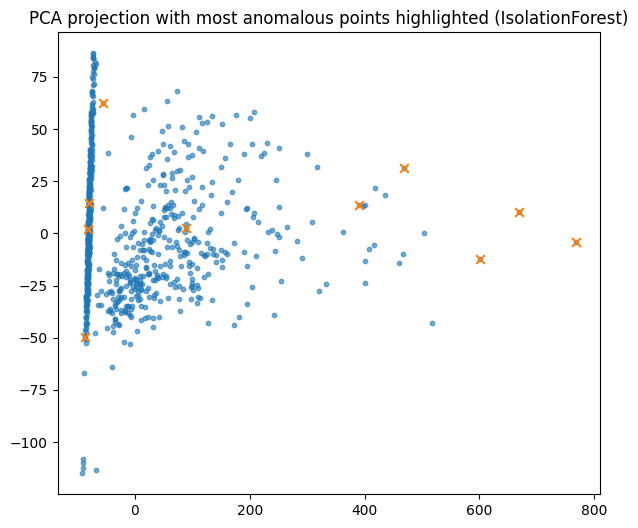

array([0.88854663, 0.06159078])

In [14]:
pca = PCA(n_components=2, random_state=RANDOM_SEED)
X2 = pca.fit_transform(X)

fig, ax = plt.subplots(figsize=(7, 6))
ax.scatter(X2[:,0], X2[:,1], s=10, alpha=0.6)
ax.scatter(X2[outlier_idx,0], X2[outlier_idx,1], s=40, marker="x")
ax.set_title("PCA projection with most anomalous points highlighted (IsolationForest)")
plt.show()

pca.explained_variance_ratio_


### 5) Multivariate alternative: robust covariance / Mahalanobis distance (conceptual)

A classical multivariate outlier score is the **Mahalanobis distance**:
$$D_M(x) = \sqrt{(x-\mu)^\top \Sigma^{-1}(x-\mu)}.$$

If the data were Gaussian, large $D_M$ would indicate a low-probability point. In practice, $\Sigma$ is distorted by outliers, so we prefer **robust covariance estimation**. Scikit-learn’s `EllipticEnvelope` implements a robust estimator (Minimum Covariance Determinant) and flags points that do not fit the main ellipsoid.

This method is most suitable when the bulk of the data is roughly elliptical in feature space. It can struggle with multi-modal distributions, which is why Isolation Forest is often a better default for heterogeneous tabular data.

In [15]:
from sklearn.covariance import EllipticEnvelope

X = df_diabetes[num_cols].astype(float).values

ee = EllipticEnvelope(contamination=0.03, random_state=RANDOM_SEED)
ee.fit(X)
ee_labels = ee.predict(X)  # -1 outlier, +1 inlier
ee_scores = ee.decision_function(X)  # higher => more inlier-like

worst = np.argsort(ee_scores)[:10]
pd.DataFrame(df_diabetes.loc[worst, num_cols].astype(float)).assign(ee_score=ee_scores[worst], ee_label=ee_labels[worst])


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,ee_score,ee_label
13,1.0,189.0,60.0,23.0,846.0,30.1,0.398,59.0,-91.183806,-1
453,2.0,119.0,0.0,0.0,0.0,19.6,0.832,72.0,-75.886598,-1
228,4.0,197.0,70.0,39.0,744.0,36.7,2.329,31.0,-49.919531,-1
579,2.0,197.0,70.0,99.0,0.0,34.7,0.575,62.0,-39.691261,-1
445,0.0,180.0,78.0,63.0,14.0,59.4,2.420,25.0,-32.880682,-1
193,11.0,135.0,0.0,0.0,0.0,52.3,0.578,40.0,-31.241225,-1
332,1.0,180.0,0.0,0.0,0.0,43.3,0.282,41.0,-27.888987,-1
247,0.0,165.0,90.0,33.0,680.0,52.3,0.427,23.0,-21.242974,-1
336,0.0,117.0,0.0,0.0,0.0,33.8,0.932,44.0,-18.895014,-1
484,0.0,145.0,0.0,0.0,0.0,44.2,0.630,31.0,-13.630177,-1


### 5.1) Advanced pattern: use an anomaly score as a feature (instead of deleting points)

Sometimes you do not want to remove outliers, but you still want the model to “know” that a case is unusual.

A pragmatic approach is:

1. Fit an unsupervised anomaly detector on training data (e.g., Isolation Forest).
2. Compute an **anomaly score** for each example.
3. Add the score as an additional feature for the supervised model.

This can help when:
- Outliers correlate with the label (e.g., rare failures produce unusual feature combinations).
- The supervised model is not expressive enough to capture “distance from normal” on its own.

As always, fit the anomaly detector only on training data to avoid leakage.

In [16]:
from sklearn.metrics import f1_score

X = df_diabetes[num_cols].astype(float).copy()
y = df_diabetes["classification"].astype(str)

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.25, stratify=y, random_state=RANDOM_SEED)

iso = IsolationForest(n_estimators=300, contamination=0.03, random_state=RANDOM_SEED)
iso.fit(Xtr.values)

# Lower score => more anomalous; we flip sign so "higher = more anomalous" for convenience
score_tr = -iso.score_samples(Xtr.values)
score_te = -iso.score_samples(Xte.values)

Xtr2 = Xtr.copy()
Xte2 = Xte.copy()
Xtr2["anomaly_score"] = score_tr
Xte2["anomaly_score"] = score_te

pipe = Pipeline([("scaler", RobustScaler()), ("clf", LogisticRegression(max_iter=2000, random_state=RANDOM_SEED))])
pipe.fit(Xtr2, ytr)
pred = pipe.predict(Xte2)

f1_macro = f1_score(yte, pred, average="macro")
f1_macro


np.float64(0.7526317443358577)

### 6) Class-aware outlier diagnostics (important in practice)

In classification problems, outliers can be class-dependent. If the minority class is inherently “extreme” (fraud, failure), it may have a higher outlier rate in some features.

A fast guardrail is: compute outlier rates **per class** and compare. Large differences are a warning sign that “cleaning” could delete minority signal.

In [17]:
# Outlier rate by class for a few features (IQR rule)
features_to_check = ["Glucose", "Insulin", "BMI", "Age"]
tmp = df_diabetes.copy()
tmp["classification"] = tmp["classification"].astype(str)

rows = []
for cls, g in tmp.groupby("classification"):
    for f in features_to_check:
        lo, hi = iqr_bounds(g[f].astype(float))
        rate = (((g[f].astype(float) < lo) | (g[f].astype(float) > hi)).mean())
        rows.append((cls, f, rate))

pd.DataFrame(rows, columns=["class","feature","iqr_outlier_rate"]).pivot(index="feature", columns="class", values="iqr_outlier_rate")


class,Diabetic,Non-Diabetic
feature,,
Age,0.003731,0.048
BMI,0.029851,0.022
Glucose,0.007463,0.028
Insulin,0.044776,0.052


### 7) “Remove vs. keep” experiment (be cautious with the interpretation)

We will do a controlled experiment:

- Build a model on the original data
- Build a model after removing rows that are outliers in *any* of several features (IQR rule)

This is **not** a recommendation to remove outliers. It is a demonstration that removal changes the training distribution and can change performance in either direction.

In [18]:
from sklearn.metrics import f1_score

X_df = df_diabetes[num_cols].astype(float)
y = df_diabetes["classification"].astype(str)

# Define a conservative outlier mask: outlier in any of selected features
sel = ["Glucose","Insulin","BMI","Age"]
mask_out = np.zeros(len(df_diabetes), dtype=bool)
for f in sel:
    lo, hi = iqr_bounds(df_diabetes[f].astype(float))
    mask_out |= (df_diabetes[f].astype(float) < lo) | (df_diabetes[f].astype(float) > hi)

df_clean = df_diabetes.loc[~mask_out].reset_index(drop=True)

def eval_simple(df):
    X = df[num_cols].astype(float)
    y = df["classification"].astype(str)
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.25, stratify=y, random_state=RANDOM_SEED)
    pipe = Pipeline([("scaler", StandardScaler()), ("clf", LogisticRegression(max_iter=2000, random_state=RANDOM_SEED))])
    pipe.fit(Xtr, ytr)
    pred = pipe.predict(Xte)
    return float(f1_score(yte, pred, average="macro")), confusion_matrix(yte, pred)

f1_raw, cm_raw = eval_simple(df_diabetes)
f1_clean, cm_clean = eval_simple(df_clean)

{
    "n_raw": len(df_diabetes),
    "n_clean": len(df_clean),
    "f1_macro_raw": round(f1_raw, 3),
    "f1_macro_clean": round(f1_clean, 3),
    "cm_raw": cm_raw,
    "cm_clean": cm_clean
}


{'n_raw': 768,
 'n_clean': 703,
 'f1_macro_raw': 0.753,
 'f1_macro_clean': 0.705,
 'cm_raw': array([[ 40,  27],
        [ 14, 111]]),
 'cm_clean': array([[ 30,  29],
        [ 14, 103]])}

### 4) Do outlier treatments change a supervised model?

There is no universal rule, but several patterns are common:

- Linear models and distance-based models can be very sensitive to heavy tails and extreme values.
- Tree ensembles are often more robust to monotone transformations and marginal outliers, but can still be affected by mislabeled extremes or leakage-like artifacts.
- “Cleaning” can **hurt** if outliers represent critical minority regimes (e.g., fraud cases).

We will compare a simple Logistic Regression pipeline across three variants:

1. Standard scaling (baseline)
2. Robust scaling (more stable under outliers)
3. Winsorization + standard scaling (cap extremes, then scale)

We will evaluate using F$_1$ (macro) and also inspect confusion matrices.

In [19]:
from sklearn.metrics import f1_score

y = df_diabetes["classification"].astype(str)
X_df = df_diabetes[num_cols].astype(float)

X_train, X_test, y_train, y_test = train_test_split(
    X_df, y, test_size=0.25, random_state=RANDOM_SEED, stratify=y
)

# 1) StandardScaler baseline
pipe_std = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=2000, random_state=RANDOM_SEED))
])

# 2) RobustScaler
pipe_robust = Pipeline([
    ("scaler", RobustScaler()),
    ("clf", LogisticRegression(max_iter=2000, random_state=RANDOM_SEED))
])

# 3) Winsorize then StandardScaler (custom transformer inline)
from sklearn.base import BaseEstimator, TransformerMixin

class Winsorizer(BaseEstimator, TransformerMixin):
    def __init__(self, lower_q=0.01, upper_q=0.99):
        self.lower_q = lower_q
        self.upper_q = upper_q
        self.los_ = None
        self.his_ = None
    
    def fit(self, X, y=None):
        X = np.asarray(X, dtype=float)
        self.los_ = np.quantile(X, self.lower_q, axis=0)
        self.his_ = np.quantile(X, self.upper_q, axis=0)
        return self
    
    def transform(self, X):
        X = np.asarray(X, dtype=float)
        return np.clip(X, self.los_, self.his_)

pipe_win = Pipeline([
    ("win", Winsorizer(0.01, 0.99)),
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=2000, random_state=RANDOM_SEED))
])

pipes = {"StandardScaler": pipe_std, "RobustScaler": pipe_robust, "Winsorize+Std": pipe_win}

rows = []
for name, pipe in pipes.items():
    pipe.fit(X_train, y_train)
    pred = pipe.predict(X_test)
    f1_macro = f1_score(y_test, pred, average="macro")
    rows.append((name, f1_macro, confusion_matrix(y_test, pred)))

rows


[('StandardScaler',
  np.float64(0.7526317443358577),
  array([[ 40,  27],
         [ 14, 111]])),
 ('RobustScaler',
  np.float64(0.7526317443358577),
  array([[ 40,  27],
         [ 14, 111]])),
 ('Winsorize+Std',
  np.float64(0.7526317443358577),
  array([[ 40,  27],
         [ 14, 111]]))]

In [20]:
for name, f1_macro, cm in rows:
    print(f"=== {name} | F1(macro)={f1_macro:.3f} ===")
    print(cm)
    print()

=== StandardScaler | F1(macro)=0.753 ===
[[ 40  27]
 [ 14 111]]

=== RobustScaler | F1(macro)=0.753 ===
[[ 40  27]
 [ 14 111]]

=== Winsorize+Std | F1(macro)=0.753 ===
[[ 40  27]
 [ 14 111]]



### Interpretation notes (what to look for)

When you compare pipelines, focus on:

- **Stability**: does performance vary wildly with small changes (seed, split, small perturbations)? Robust treatments often reduce variance.
- **Error profile**: do we reduce high-cost errors? Confusion matrices help.
- **Reasonableness**: do transformed features still have meaningful relationships? (Sometimes capping too aggressively removes signal.)

Remember: if outliers are *the minority you care about*, “fixing” them can erase the problem you are trying to model.

## Part B — Imbalanced data

### 1) Core concepts and why accuracy fails

Let the minority class prevalence be $\pi = P(y=1)$. If $\pi$ is small, a trivial classifier that always predicts $0$ can have accuracy $(1-\pi)$, which may look “good” but has **zero utility**.

Under imbalance, you must shift from accuracy to metrics aligned with the decision process:

- **Precision**: $P = \dfrac{TP}{TP+FP}$
- **Recall**: $R = \dfrac{TP}{TP+FN}$
- **F$_1$**: $F_1 = 2 \dfrac{PR}{P+R}$
- **PR-AUC (Average Precision)**: summarizes the precision–recall curve and is often more informative than ROC-AUC for rare events.

A practical way to talk about the problem is the **imbalance ratio**:
$$IR = \dfrac{n_{majority}}{n_{minority}}.$$
When $IR$ is large, you almost always need special evaluation and training strategies.

## Pipeline ordering for outliers and imbalance (details you should internalize)

Ordering matters because some operations “learn” from the data (estimate parameters) and must be trained only on the training fold:

### Outliers in pipelines
- **Capping/winsorization** estimates quantiles → must be fitted on training folds.
- **Power transforms** estimate parameters → training-only.
- **Scaling** estimates mean/std or median/IQR → training-only.
- **Outlier deletion** changes the training distribution → must be done using rules derived from training data.

### Imbalance in pipelines
- **Resampling** uses neighborhood structure / duplication → must happen within training folds only.
- **Threshold tuning** uses performance curves → tune on validation only, then freeze.

A leak-safe structure for imbalanced classification typically looks like:

1. Split / CV fold
2. Fit preprocessing (encoders/scalers) on training fold
3. Resample training fold (optional)
4. Fit classifier
5. Evaluate on untouched validation/test fold

If you violate this order, your metrics can become systematically optimistic.

In [21]:
drug_fallback = """Age,Sex,BP,Cholesterol,Na_to_K,Drug
23,F,HIGH,HIGH,25.355,DrugY
47,M,LOW,HIGH,13.093,drugC
47,M,LOW,HIGH,10.114,drugC
28,F,NORMAL,HIGH,7.798,drugX
61,F,LOW,HIGH,18.043,DrugY
22,F,NORMAL,HIGH,8.607,drugX
"""
df_drug = _load_csv("../../../Datasets/Classification/drug200.csv", drug_fallback)

# Expand for demonstration and then enforce a stronger imbalance in the binary label.
if len(df_drug) < 500:
    df_drug = _expand_tabular(df_drug, n=1200, noise_scale=0.02)

df_drug["is_DrugY"] = (df_drug["Drug"].astype(str).str.lower() == "drugy").astype(int)

# Enforce stronger imbalance: keep all majority and downsample minority
minority = df_drug[df_drug["is_DrugY"] == 1]
majority = df_drug[df_drug["is_DrugY"] == 0]

target_minority = max(int(0.10 * len(majority)), 40)  # ~10% prevalence
minority_down = minority.sample(n=min(target_minority, len(minority)), random_state=RANDOM_SEED)

df_drug_bin = pd.concat([majority, minority_down], axis=0).sample(frac=1.0, random_state=RANDOM_SEED).reset_index(drop=True)

df_drug_bin["is_DrugY"].value_counts(normalize=True).rename("prevalence")


is_DrugY
0    0.909091
1    0.090909
Name: prevalence, dtype: float64

In [22]:
X = df_drug_bin[["Age","Sex","BP","Cholesterol","Na_to_K"]].copy()
y = df_drug_bin["is_DrugY"].astype(int)

cat_cols = ["Sex","BP","Cholesterol"]
num_cols2 = ["Age","Na_to_K"]

preprocess = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ("num", StandardScaler(), num_cols2)
])

# Baseline logistic regression (no class weights)
baseline = Pipeline([
    ("prep", preprocess),
    ("clf", LogisticRegression(max_iter=2000, random_state=RANDOM_SEED))
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_SEED, stratify=y
)

baseline.fit(X_train, y_train)
pred = baseline.predict(X_test)
proba = baseline.predict_proba(X_test)[:, 1]

print("Confusion matrix:")
print(confusion_matrix(y_test, pred))
print()
print(classification_report(y_test, pred, digits=3))
print("ROC-AUC:", roc_auc_score(y_test, proba).round(3))
print("PR-AUC (Average Precision):", average_precision_score(y_test, proba).round(3))


Confusion matrix:
[[163   0]
 [  3  13]]

              precision    recall  f1-score   support

           0      0.982     1.000     0.991       163
           1      1.000     0.812     0.897        16

    accuracy                          0.983       179
   macro avg      0.991     0.906     0.944       179
weighted avg      0.984     0.983     0.982       179

ROC-AUC: 1.0
PR-AUC (Average Precision): 1.0


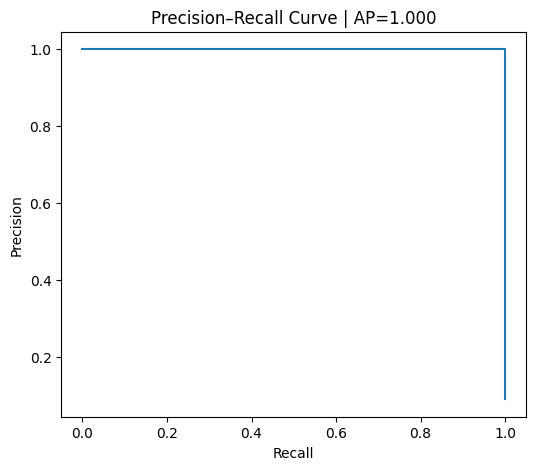

,precision,recall
0,0.089385,1.0
1,0.089888,1.0
2,0.090395,1.0
3,0.090909,1.0
4,0.091429,1.0
5,0.091954,1.0
6,0.092486,1.0
7,0.093023,1.0
8,0.093567,1.0
9,0.094118,1.0


In [23]:
prec, rec, thr = precision_recall_curve(y_test, proba)
ap = average_precision_score(y_test, proba)

fig, ax = plt.subplots(figsize=(6, 5))
ax.plot(rec, prec)
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_title(f"Precision–Recall Curve | AP={ap:.3f}")
plt.show()

pd.DataFrame({"precision": prec[:10], "recall": rec[:10]}).head(10)


### 2) Dataset 2 (Categorical + numeric): `drug200.csv`

This dataset has categorical variables (Sex, BP, Cholesterol) plus a numeric feature (Na_to_K). We will:

1. Create a binary target: DrugY vs. not-DrugY (typical “rare event” framing).
2. Train a baseline model and show why accuracy can mislead.
3. Improve the model using (a) class weights, (b) resampling (SMOTE/over/under), and (c) threshold tuning.

Critically, we will implement everything inside a **pipeline** so the preprocessing is fit only on the training folds (leak-safe).

In [24]:
weighted = Pipeline([
    ("prep", preprocess),
    ("clf", LogisticRegression(max_iter=2000, random_state=RANDOM_SEED, class_weight="balanced"))
])
weighted.fit(X_train, y_train)
pred_w = weighted.predict(X_test)
proba_w = weighted.predict_proba(X_test)[:, 1]

print("Confusion matrix:")
print(confusion_matrix(y_test, pred_w))
print()
print(classification_report(y_test, pred_w, digits=3))
print("ROC-AUC:", roc_auc_score(y_test, proba_w).round(3))
print("PR-AUC (Average Precision):", average_precision_score(y_test, proba_w).round(3))


Confusion matrix:
[[162   1]
 [  0  16]]

              precision    recall  f1-score   support

           0      1.000     0.994     0.997       163
           1      0.941     1.000     0.970        16

    accuracy                          0.994       179
   macro avg      0.971     0.997     0.983       179
weighted avg      0.995     0.994     0.994       179

ROC-AUC: 1.0
PR-AUC (Average Precision): 1.0


### 1.1) PR curves have a baseline (use it)

The precision–recall curve has a simple baseline: a random classifier achieves expected precision equal to the **prevalence** $\pi$.

That means:

- If $\pi = 0.10$, then AP values around 0.10 are “random-like.”
- A PR curve that sits only slightly above $\pi$ is not strong, even if ROC-AUC looks decent.

Plotting the baseline helps you interpret PR curves correctly.

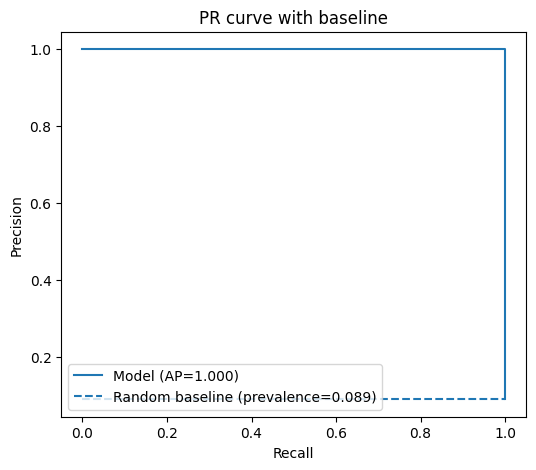

In [25]:
pi = y_test.mean()
prec, rec, thr = precision_recall_curve(y_test, proba_w)
ap = average_precision_score(y_test, proba_w)

fig, ax = plt.subplots(figsize=(6, 5))
ax.plot(rec, prec, label=f"Model (AP={ap:.3f})")
ax.hlines(pi, xmin=0, xmax=1, linestyles="--", label=f"Random baseline (prevalence={pi:.3f})")
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_title("PR curve with baseline")
ax.legend()
plt.show()


### 2.1) Operational metrics: precision@k and “review queues”

In many imbalanced problems you do not act on every prediction. Instead, you rank cases by risk and review only the top $k$ (or top $q\%$).

In that setting, you care about:

- **Precision@k**: among the top $k$ highest-risk cases, what fraction are truly positive?
- **Recall@k**: what fraction of all positives are captured within the reviewed set?
- Capacity constraints: $k$ is often fixed by staffing and budget.

These metrics connect directly to operations (fraud review teams, medical triage, incident response).

In [26]:
# Use the weighted model's probabilities on the test set
scores = pd.DataFrame({"y": y_test.values, "proba": proba_w}).sort_values("proba", ascending=False).reset_index(drop=True)

k = 50
topk = scores.head(k)

precision_k = topk["y"].mean()
recall_k = topk["y"].sum() / scores["y"].sum()

precision_k, recall_k, scores["y"].mean()


(np.float64(0.32), np.float64(1.0), np.float64(0.0893854748603352))

### 2.2) Prevalence shift and recalibration (a subtle but important issue)

Training data prevalence is not always the same as deployment prevalence. Example: your historical data might contain many investigations (enriched positives), but production is mostly normal cases.

If prevalence shifts, two things can happen:

1. **Ranking quality** may remain acceptable (ROC-AUC, PR-AUC), but  
2. **Probability calibration** and optimal thresholds can change.

Practical guardrails:

- Monitor prevalence and decision rates over time.
- Re-tune thresholds when business costs or prevalence changes.
- Consider probability calibration (Platt scaling / isotonic regression) when you depend on calibrated probabilities for decision-making.

You will revisit calibration in later chapters, but you should already treat “threshold = 0.5” as a modeling smell in imbalanced settings.

### 1.2) Cost-based thresholding: closed-form rule (when probabilities are calibrated)

Suppose the cost of a false positive is $c_{FP}$ and the cost of a false negative is $c_{FN}$.

If the model produces a calibrated probability $\hat{p}=P(y=1\mid x)$, the Bayes-optimal decision is:

Predict $1$ if
$$\hat{p} > \frac{c_{FP}}{c_{FP}+c_{FN}}.$$

This is a useful anchor, but in practice you should still tune on validation data because probabilities may not be perfectly calibrated, and operational constraints (capacity limits, review queues) matter.

In [27]:
c_fp = 1.0
c_fn = 10.0
tau = c_fp / (c_fp + c_fn)
tau


0.09090909090909091

In [28]:
pred_cost = (proba_w >= tau).astype(int)
print(f"Cost-based tau={tau:.3f} (c_fp={c_fp}, c_fn={c_fn})")
print(confusion_matrix(y_test, pred_cost))
print()
print(classification_report(y_test, pred_cost, digits=3))


Cost-based tau=0.091 (c_fp=1.0, c_fn=10.0)
[[138  25]
 [  0  16]]

              precision    recall  f1-score   support

           0      1.000     0.847     0.917       163
           1      0.390     1.000     0.561        16

    accuracy                          0.860       179
   macro avg      0.695     0.923     0.739       179
weighted avg      0.945     0.860     0.885       179



### 1.3) Tree ensembles and imbalance

Random Forests and Gradient Boosting are often strong baselines on tabular data. For imbalance, tree models can use `class_weight` (or related variants) to increase minority influence.

You still must evaluate with PR-AUC and tuned thresholds, because tree models can achieve high accuracy by following the base rate.

In [29]:
rf = Pipeline([
    ("prep", preprocess),
    ("clf", RandomForestClassifier(
        n_estimators=400,
        random_state=RANDOM_SEED,
        class_weight="balanced_subsample"
    ))
])

rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)
proba_rf = rf.predict_proba(X_test)[:, 1]

print(confusion_matrix(y_test, pred_rf))
print()
print(classification_report(y_test, pred_rf, digits=3))
print("ROC-AUC:", roc_auc_score(y_test, proba_rf).round(3))
print("PR-AUC:", average_precision_score(y_test, proba_rf).round(3))


[[163   0]
 [  0  16]]

              precision    recall  f1-score   support

           0      1.000     1.000     1.000       163
           1      1.000     1.000     1.000        16

    accuracy                          1.000       179
   macro avg      1.000     1.000     1.000       179
weighted avg      1.000     1.000     1.000       179

ROC-AUC: 1.0
PR-AUC: 1.0


### 3) Class weighting (cost-sensitive learning in a simple form)

Many classifiers support `class_weight="balanced"`, which reweights the loss so that minority errors matter more. This is a principled first option because:

- It keeps all data (no synthetic points).
- It is easy to validate with cross-validation.
- It often improves recall on the minority class without excessive overfitting.

However, it does **not** change the feature distribution; if the minority class is small and complex, weighting alone may be insufficient.

In [30]:
if not IMBLEARN_AVAILABLE:
    print("imblearn is not available in this environment.")
else:
    # Note: SMOTE happens after preprocessing to ensure numeric feature space.
    # For one-hot encoded categorical features, SMOTE can still work, but you must validate carefully.
    smote = SMOTE(random_state=RANDOM_SEED, k_neighbors=5)
    ros = RandomOverSampler(random_state=RANDOM_SEED)
    rus = RandomUnderSampler(random_state=RANDOM_SEED)

    def eval_model(pipeline, name):
        pipeline.fit(X_train, y_train)
        pred = pipeline.predict(X_test)
        proba = pipeline.predict_proba(X_test)[:, 1]
        ap = average_precision_score(y_test, proba)
        roc = roc_auc_score(y_test, proba)
        return name, ap, roc, confusion_matrix(y_test, pred)

    pipe_smote = ImbPipeline([
        ("prep", preprocess),
        ("smote", smote),
        ("clf", LogisticRegression(max_iter=2000, random_state=RANDOM_SEED))
    ])

    pipe_ros = ImbPipeline([
        ("prep", preprocess),
        ("ros", ros),
        ("clf", LogisticRegression(max_iter=2000, random_state=RANDOM_SEED))
    ])

    pipe_rus = ImbPipeline([
        ("prep", preprocess),
        ("rus", rus),
        ("clf", LogisticRegression(max_iter=2000, random_state=RANDOM_SEED))
    ])

    results = []
    for nm, pp in [("SMOTE", pipe_smote), ("RandomOverSampler", pipe_ros), ("RandomUnderSampler", pipe_rus)]:
        results.append(eval_model(pp, nm))

    results


### 4) Resampling (over/under-sampling) and SMOTE

Resampling changes the training distribution:

- **Under-sampling** removes majority samples (fast, but may discard information).
- **Over-sampling** duplicates minority samples (can overfit).
- **SMOTE** synthesizes new minority samples by interpolating between neighbors in feature space.

Key risk: if resampling is done *before* splitting or cross-validation, it leaks information. The correct pattern is:

- Split first, then resample **inside the training fold only**, ideally using an `imblearn` pipeline.

We will compare three resampling strategies, if `imblearn` is available.

### 4.1) SMOTE caveats (what strong practitioners watch for)

SMOTE is powerful, but it is not free:

- **Geometry assumptions:** SMOTE interpolates in feature space. If the minority class is multi-modal, interpolation can generate unrealistic points.
- **Categorical variables:** naive SMOTE on one-hot spaces can create fractional “hybrid” points. This is sometimes acceptable for linear models, but you must validate. For truly categorical features, prefer SMOTENC or use class-weighting / tree models.
- **High-dimensional sparsity:** in sparse spaces, nearest neighbors may be far away and interpolation becomes less meaningful.
- **Evaluation:** SMOTE can overfit when the minority class is tiny. Use cross-validation and check variance across folds.

A practical workflow is:
1) try class weights and thresholding first;  
2) add resampling only if you need more minority support and CV confirms an improvement.

In [31]:
# Use the weighted model probabilities as an example for threshold tuning
proba = proba_w.copy()

prec, rec, thr = precision_recall_curve(y_test, proba)

# Threshold array is length-1 compared to precision/recall
# We'll compute F1 for each threshold and pick the best.
f1 = 2 * (prec[:-1] * rec[:-1]) / (prec[:-1] + rec[:-1] + 1e-12)
best_idx = int(np.argmax(f1))
best_thr = float(thr[best_idx])

best_thr, float(f1[best_idx]), float(prec[best_idx]), float(rec[best_idx])


(0.7593278765876826, 0.9999999999995, 1.0, 1.0)

In [32]:
thr = best_thr
pred_thr = (proba >= thr).astype(int)

print(f"Threshold = {thr:.3f}")
print("Confusion matrix:")
print(confusion_matrix(y_test, pred_thr))
print()
print(classification_report(y_test, pred_thr, digits=3))


Threshold = 0.759
Confusion matrix:
[[163   0]
 [  0  16]]

              precision    recall  f1-score   support

           0      1.000     1.000     1.000       163
           1      1.000     1.000     1.000        16

    accuracy                          1.000       179
   macro avg      1.000     1.000     1.000       179
weighted avg      1.000     1.000     1.000       179



### 5) Threshold tuning (decision-focused evaluation)

Most classifiers output probabilities $\hat{p}(y=1 \mid x)$. The default threshold of $0.5$ is rarely optimal under imbalance.

You can choose a threshold $\tau$ based on:

- Target **recall** (e.g., “catch 95% of fraud”)
- Target **precision** (e.g., “no more than 5% false positives”)
- **Expected cost** if you can quantify costs $c_{FP}$ and $c_{FN}$:
  $$C(\tau) = c_{FP}\,FP(\tau) + c_{FN}\,FN(\tau).$$

In practice, you tune $\tau$ on validation data (or via CV) and then freeze it for test reporting.

In [33]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

# Compare baseline vs weighted in CV using PR-AUC proxy
scores_baseline = cross_val_score(baseline, X, y, cv=skf, scoring="average_precision")
scores_weighted = cross_val_score(weighted, X, y, cv=skf, scoring="average_precision")

pd.DataFrame({
    "baseline_AP": scores_baseline,
    "weighted_AP": scores_weighted
}).assign(
    baseline_mean=scores_baseline.mean(),
    weighted_mean=scores_weighted.mean()
)


,baseline_AP,weighted_AP,baseline_mean,weighted_mean
0,1.0,1.000000,1.0,0.998901
1,1.0,0.994505,1.0,0.998901
2,1.0,1.000000,1.0,0.998901
3,1.0,1.000000,1.0,0.998901
4,1.0,1.000000,1.0,0.998901


### Cross-validation for resampled pipelines (how to validate properly)

A single train/test split is not enough when the minority class is small. Cross-validation gives you a distribution of scores, which helps you detect overfitting and instability.

Below we compute stratified CV scores for a SMOTE pipeline (when available) using PR-AUC proxy (`average_precision`).

In [34]:
if not IMBLEARN_AVAILABLE:
    print("imblearn is not available.")
else:
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
    smote_pipe = ImbPipeline([
        ("prep", preprocess),
        ("smote", SMOTE(random_state=RANDOM_SEED)),
        ("clf", LogisticRegression(max_iter=2000, random_state=RANDOM_SEED))
    ])
    scores_smote = cross_val_score(smote_pipe, X, y, cv=skf, scoring="average_precision")
    pd.DataFrame({"smote_AP": scores_smote}).assign(mean=scores_smote.mean(), std=scores_smote.std())


### Reporting uncertainty (what you should do when positives are rare)

With rare positives, metric estimates can have high variance. Two practitioners can run the “same” experiment and get noticeably different numbers simply due to sampling noise.

Good reporting habits:

- Use repeated CV (or multiple random splits) and report mean ± std.
- For operational metrics (precision@k), report confidence intervals via bootstrap.
- Always include confusion matrices at the chosen threshold; they reveal whether the model is actually catching positives.

If you ever see a large performance jump after resampling, treat it as a hypothesis and validate with multiple folds.

### 6) Cross-validation with appropriate scoring

Under imbalance, you should choose scoring functions that reflect what you care about. Examples:

- `average_precision` (PR-AUC proxy) for rare-event ranking quality.
- `roc_auc` for ranking (but interpret carefully when prevalence is small).
- `f1`, `f1_macro`, or `balanced_accuracy` for thresholded decisions.

We will compute CV scores using **stratified** folds to preserve class proportions across folds.

### 7) Brief note: imbalanced multi-class and long-tail labels

Class imbalance is not only binary. In multi-class settings you often see a *long tail*:

- Many samples for a few “head” classes
- Very few samples for several “tail” classes

Key adaptations:

- Use macro-averaged metrics (macro F$_1$) to avoid being dominated by head classes.
- Consider hierarchical labeling (if appropriate) or merging ultra-rare classes (if semantically valid).
- Use class-weighting in multi-class models (many scikit-learn classifiers support it).
- Evaluate per-class recall and precision; “overall” numbers can hide failures on tail classes.

Even if you do not resample, *reporting* must reflect the long tail.

## Part C — Putting it together: common failure modes and guardrails

### Failure mode 1: “Outlier removal” that deletes minority-class signal
If rare events are the minority class (fraud, failure), they can look like outliers. Deleting “outliers” can remove the very examples you need.

**Guardrail:** examine outlier rates by class: does the minority class have more extremes? If yes, treat carefully and prefer robust models or class-aware transformations.

### Failure mode 2: Resampling leakage
If you oversample before the split, you can end up with duplicates (or synthetic neighbors) in both train and test, inflating metrics.

**Guardrail:** resample only within training folds using an `imblearn` pipeline.

### Failure mode 3: Optimizing the wrong metric
Accuracy can be meaningless under imbalance. ROC-AUC can also be optimistic when you care about precision at high recall.

**Guardrail:** decide *operational* goals first (costs, target recall/precision) and report PR-AUC, confusion matrices at tuned thresholds, and cost-based summaries.

### Failure mode 4: Treating outliers without tracing their origin
A unit mismatch (e.g., mg/dL vs mmol/L) is not solved by winsorization; it is solved by fixing the pipeline.

**Guardrail:** log and audit data lineage; monitor distributions by source and time.

## Production considerations (brief but important)

Even if your offline evaluation looks strong, outliers and imbalance can break models in production if you do not monitor and govern them.

### Monitoring outliers
- Track robust quantiles (p1/p5/p50/p95/p99) of key features over time.
- Track anomaly-score distributions if you use an unsupervised detector.
- Segment monitoring by source, geography, device type, and other operational slices.
- Investigate “new outliers” quickly: they may indicate drift, pipeline bugs, or a new regime.

### Monitoring imbalance
- Track prevalence (base rate) over time and by segment.
- Track decision rates: how many positives are predicted at the chosen threshold?
- If you operate a review queue, track precision@k and throughput constraints.
- Re-tune thresholds when costs change (policy updates, staffing levels) or when prevalence shifts.

### Governance
- Log outlier-handling rules and resampling choices as part of your model card / experiment tracking.
- Prefer reversible, explainable preprocessing over ad-hoc deletion.
- Keep a small “edge-case” test suite: examples that are rare but high-impact.

These practices are the difference between a model that demos well and a model that survives contact with reality.

## Checklist for real projects (use this as a repeatable procedure)

### Outliers
- [ ] Inspect distributions (histogram, boxplot) and summary quantiles.
- [ ] Run two detectors: one robust univariate (IQR/MAD) and one multivariate (IsolationForest).
- [ ] Segment by **time**, **source**, and **label** to detect drift vs. rare valid cases.
- [ ] Choose treatment: delete only if clearly wrong; otherwise use robust scaling / transformation / robust model.
- [ ] Re-evaluate with leak-safe CV and compare error profiles, not just a single metric.

### Imbalance
- [ ] Report prevalence and imbalance ratio.
- [ ] Use stratified splits and consider group/time splits when relevant.
- [ ] Prefer PR-AUC and tuned-threshold confusion matrices.
- [ ] Try class weighting first; then consider resampling inside pipelines.
- [ ] Tune thresholds using validation and freeze for test reporting.

## Exercises (do these to build “bandwidth”)

1. **Outlier diagnosis:** In `salaries.csv`, identify whether high salaries are errors or plausible extremes. Implement (a) deletion, (b) winsorization, and (c) robust modeling, and compare results.
2. **Class-aware outliers:** In the drug dataset, check whether minority class has a higher outlier rate in `Na_to_K`. Does winsorization change minority recall?
3. **Thresholding under costs:** Suppose $c_{FN}=10$ and $c_{FP}=1$. Tune a threshold that minimizes expected cost on validation.
4. **Resampling comparison:** Compare RandomOverSampler vs. SMOTE. Which one overfits more in your CV? How can you tell?
5. **Reporting:** Write a short report that includes prevalence, PR-AUC, and a confusion matrix at the chosen threshold, plus the rationale for the threshold.

In [35]:
salaries_fallback = """Name,Age,Job,Salary
Kevin Sanders,24,Software Engineer,7300
Lisa Mills,26,High School Teacher,6100
Donna Allison,27,Dentist,12700
Michael Schmitt,43,Dentist,17500
Lisa Shaffer,31,Accountant,7400
"""
df_sal = _load_csv("../../../Datasets/Regression/salaries.csv", salaries_fallback)

if len(df_sal) < 200:
    df_sal = _expand_tabular(df_sal, n=500, noise_scale=0.08)

# Inject a few extreme salaries (to mimic executives / anomalies)
df_sal.loc[:4, "Salary"] = df_sal.loc[:4, "Salary"].astype(float) * np.array([1, 1, 3.5, 6.0, 2.0])

df_sal.head()


,Name,Age,Job,Salary
0,Kevin Sanders,24,Software Engineer,7300
1,Lisa Mills,26,High School Teacher,6100
2,Donna Allison,27,Dentist,44450
3,Michael Schmitt,43,Dentist,105000
4,Lisa Shaffer,31,Accountant,14800


In [36]:
x = df_sal["Salary"].astype(float)
lo, hi = iqr_bounds(x, k=1.5)
flags_iqr = (x < lo) | (x > hi)

z_mad = robust_z_mad(x)
flags_mad = np.abs(z_mad) > 3.5

pd.DataFrame({
    "Salary": x,
    "IQR_flag": flags_iqr,
    "robust_z(MAD)": z_mad,
    "MAD_flag": flags_mad
}).sort_values("Salary", ascending=False).head(15), (lo, hi), flags_iqr.mean(), flags_mad.mean()


(       Salary  IQR_flag  robust_z(MAD)  MAD_flag
 3    105000.0      True      19.328641      True
 2     44450.0      True       6.565836      True
 262   24100.0     False       2.276437     False
 873   23600.0     False       2.171047     False
 741   23600.0     False       2.171047     False
 901   23500.0     False       2.149969     False
 292   23100.0     False       2.065656     False
 92    22800.0     False       2.002422     False
 923   22800.0     False       2.002422     False
 653   22800.0     False       2.002422     False
 732   22600.0     False       1.960266     False
 410   22600.0     False       1.960266     False
 599   22500.0     False       1.939187     False
 296   22500.0     False       1.939187     False
 711   22500.0     False       1.939187     False,
 (np.float64(550.0), np.float64(26550.0)),
 np.float64(0.002),
 np.float64(0.002))

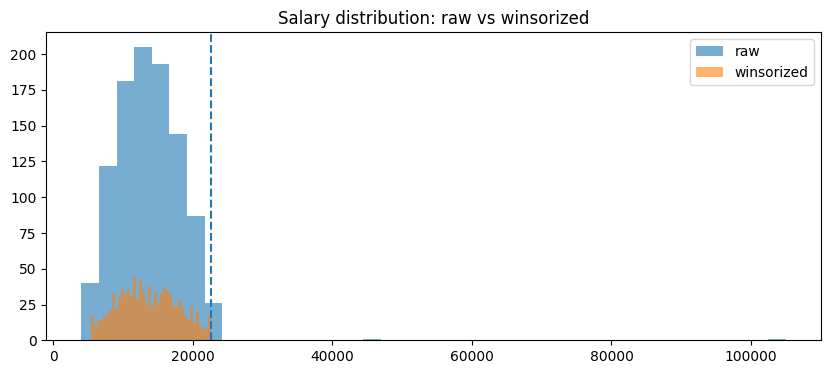

,raw,winsorized
count,1000.00000,1000.000000
mean,13736.15000,13632.010000
std,5219.13547,4231.217628
min,4000.00000,5399.000000
1%,5399.00000,5399.990000
5%,6900.00000,6900.000000
50%,13300.00000,13300.000000
95%,20700.00000,20700.000000
99%,22602.00000,22600.020000
max,105000.00000,22602.000000


In [37]:
x_w, w_lo, w_hi = winsorize_series(x, 0.01, 0.99)

fig, ax = plt.subplots(figsize=(10, 4))
ax.hist(x, bins=40, alpha=0.6, label="raw")
ax.hist(x_w, bins=40, alpha=0.6, label="winsorized")
ax.axvline(w_hi, linestyle="--")
ax.set_title("Salary distribution: raw vs winsorized")
ax.legend()
plt.show()

pd.DataFrame({
    "raw": x.describe(percentiles=[0.01,0.05,0.5,0.95,0.99]),
    "winsorized": x_w.describe(percentiles=[0.01,0.05,0.5,0.95,0.99])
})
